In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from prnn.analysis.TuningCurveAnalysis import TuningCurveAnalysis
from prnn.utils.predictiveNet import PredictiveNet
import numpy as np
import matplotlib.pyplot as plt

import itertools
import pandas as pd


In [3]:
savefolder = 'Figures/20250507_Grid_LogNOrthogonalization/'

In [4]:
nettypes = ['thRNN_5win','lognRNN_mask']
# kvalues = ['2']
# hpidx = ['0','1','2','3','4']
seeds = ['42', '1042', '2042', '3042', '4042', '5042', '6042', '7042', '8042', '9042']
actenc = ['ContSpeedOnehotHD']

netprops = itertools.product(*[nettypes,['-'],actenc,['-s'],seeds])
netprops = list(netprops)
netnames = [''.join(name) for name in netprops]
nettype = [name[0] for name in netprops]
#netcontext = [name[3] for name in netprops]
netseed = [int(name[4]) for name in netprops]
#netdirect = [name[2] for name in netprops]

netFolder = '/home/mila/a/aleksei.efremov/pRNN/' #Abs path
netsubfolder = 'example_net_RiaB_grid_batch8/'

analysisFrame = pd.DataFrame(data={'filename':netnames, 'type':nettype, 'seed':netseed, 
                                        'netfolder':netFolder, 'netsubfolder':netsubfolder})

In [5]:
def loadNet(row):
    try:
        net = PredictiveNet.loadNet(row['netsubfolder']+row['filename'],savefolder = row['netfolder'], suppressText=True)
        return net
    except:
        print(f"{row['filename']} does not exist")
        #net = PredictiveNet
        net = None
        return net

analysisFrame['net'] = analysisFrame.apply(loadNet, axis = 1)

In [6]:
def getHparms(row):
    predictiveNet = loadNet(row)
    if predictiveNet is None:
        return
    parms = {
        'mean_std_ratio' : predictiveNet.trainArgs.mean_std_ratio,
        'sparsity' : predictiveNet.trainArgs.sparsity,
        'NNeurons' : predictiveNet.trainArgs.hiddensize,
        'eg_weight_decay' : predictiveNet.trainArgs.eg_weight_decay,
        'eg_lr' : predictiveNet.trainArgs.eg_lr,
        }

    return pd.Series(parms)

hparms = analysisFrame.apply(getHparms, axis = 1)
analysisFrame = analysisFrame.join(hparms)
analysisFrame = analysisFrame.dropna()

#max_msr = analysisFrame['mean_std_ratio'].max()
#analysisFrame['mean_std_ratio'][analysisFrame['type']=='thcycRNN_5win_full']=max_msr*10


In [7]:
def getPredPerformance(row):
    #predictiveNet = row['net']
    predictiveNet = loadNet(row)
    try:
        finalLoss = predictiveNet.TrainingSaver['loss'].values[-1]
    except:
        try:
            finalLoss = predictiveNet.TrainingSaver['loss']
        except:
            finalLoss = predictiveNet.TrainingSaver.transpose()['loss']
        
    
    return finalLoss 

analysisFrame['finalLoss'] = analysisFrame.apply(getPredPerformance, axis = 1)

In [8]:
#Calculate spatial info and decoding performance
def getSpatialRep(row):
    predictiveNet = loadNet(row)
    #print(len(predictiveNet.TrainingSaver['sRSA'].values))
    numepochs = len(predictiveNet.TrainingSaver['sRSA'].values)
    try:
        SI = predictiveNet.TrainingSaver['SI'].values[-1]
        sRSA = predictiveNet.TrainingSaver['sRSA'].values[-1]

        EVs = predictiveNet.TrainingSaver['EVs'].values[-1]
        
        SWdist = predictiveNet.TrainingSaver['SWdist'].values[-1]
        finalLoss = predictiveNet.TrainingSaver['loss'].values[-1]
    except:
        try:
            SI = predictiveNet.TrainingSaver['SI']
            sRSA = predictiveNet.TrainingSaver['sRSA']

            EVs = predictiveNet.TrainingSaver['EVs']

            SWdist = predictiveNet.TrainingSaver['SWdist']
            finalLoss = predictiveNet.TrainingSaver['loss']
        except:
            SI = predictiveNet.TrainingSaver.transpose()['SI'].values[-1]
            sRSA = predictiveNet.TrainingSaver.transpose()['sRSA'].values[-1]

            EVs = predictiveNet.TrainingSaver.transpose()['EVs'].values[-1]

            SWdist = predictiveNet.TrainingSaver.transpose()['SWdist'].values[-1]
            finalLoss = predictiveNet.TrainingSaver.transpose()['loss'].values[-1]
    
    meanSI = np.nanmean(SI)
    EVsp50 = np.nanmean(EVs>0.5)
    tunedSI = np.nanmean(SI[EVs>0.5])

    # pUntuned = predictiveNet.TrainingSaver['celltype_Fraction'].values[0][0]
    # #NOTE: this should be changed to call the index for single field cells from cell type names...
    # pSingleField = predictiveNet.TrainingSaver['celltype_Fraction'].values[0][3]
    # pSingleField = pSingleField / (1-np.sum(predictiveNet.TrainingSaver['celltype_Fraction'].values[0][0:2]))
    
    # dh0 = predictiveNet.TrainingSaver['dh0'].values[0]
    # dhInf = predictiveNet.TrainingSaver['dhInf'].values[0]
    # dx_half = predictiveNet.TrainingSaver['dx_half'].values[0]

    return (SI, meanSI, sRSA, EVs, EVsp50, finalLoss, SWdist, tunedSI, numepochs, 
            # pUntuned, pSingleField, dh0, dhInf, dx_half
            )
            
analysisFrame[['SI','meanSI','sRSA','EVs','EVs50','finalLoss',
                'SWdist','tunedSI','numepochs',
                # 'pUntuned','pSingleField',
                # 'dh0','dhInf','dx_half'
                ]] = analysisFrame.apply(getSpatialRep, axis = 1, result_type="expand")


In [15]:
exseed = 42
compareFrame = analysisFrame[analysisFrame['seed']==exseed]
compareFrame
predictiveNet_uniform = loadNet(compareFrame.loc[0])
predictiveNet_logN = loadNet(compareFrame.loc[10])
#compareFrame
compareFrame

,filename,type,seed,netfolder,netsubfolder,net,mean_std_ratio,sparsity,NNeurons,eg_weight_decay,...,meanSI,sRSA,EVs,EVs50,SWdist,tunedSI,numepochs,TCA,groupFrac,groupFrac_welltuned
0,thRNN_5win-ContSpeedOnehotHD-s42,thRNN_5win,42,/home/mila/a/aleksei.efremov/pRNN/,example_net_RiaB_grid_batch8/,<prnn.utils.predictiveNet.PredictiveNet object...,1.0,0.1,500.0,1.000000e-08,...,1.240971,0.47529,"[0.551574, 0.19637829, -0.12331247, 0.23335582...",0.080,0.117659,2.108383,61441,<prnn.analysis.TuningCurveAnalysis.TuningCurve...,"[0.124, 0.064, 0.14, 0.028, 0.116, 0.528]","[0.0, 0.0, 0.2527075812274368, 0.0397111913357..."
10,lognRNN_mask-ContSpeedOnehotHD-s42,lognRNN_mask,42,/home/mila/a/aleksei.efremov/pRNN/,example_net_RiaB_grid_batch8/,<prnn.utils.predictiveNet.PredictiveNet object...,1.0,0.1,500.0,1.000000e-08,...,1.312966,0.66119,"[0.5731811, 0.3732745, 0.22128129, 0.59554005,...",0.208,0.055371,1.575529,61441,<prnn.analysis.TuningCurveAnalysis.TuningCurve...,"[0.05, 0.038, 0.312, 0.028, 0.07, 0.502]","[0.0, 0.0, 0.42391304347826086, 0.038043478260..."


In [14]:

def calculateTCA(row):
    predictiveNet = loadNet(row)
    predictiveNet.EnvLibrary[0].start_pos = 0
    print(row['filename'])
    TCA = TuningCurveAnalysis(predictiveNet, timesteps_wake=10000)
    #TCA.cellClassificationFigure()
    plt.show()

    return TCA, TCA.groupFrac, TCA.groupFrac_welltuned

# compareFrame[['TCA','groupFrac','groupFrac_welltuned']] = compareFrame.apply(calculateTCA, axis = 1, result_type="expand")
analysisFrame[['TCA','groupFrac','groupFrac_welltuned']] = analysisFrame.apply(calculateTCA, axis = 1, result_type="expand")


thRNN_5win-ContSpeedOnehotHD-s42
Calculating EV_s
Running WAKE


/home/mila/a/aleksei.efremov/pRNN/prnn/analysis/TuningCurveAnalysis.py:517: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = np.cov(coords.T)
/home/mila/a/aleksei.efremov/venvs/PredictiveReplay_39/lib/python3.9/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/mila/a/aleksei.efremov/venvs/PredictiveReplay_39/lib/python3.9/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


thRNN_5win-ContSpeedOnehotHD-s1042
Calculating EV_s
Running WAKE
thRNN_5win-ContSpeedOnehotHD-s2042
Calculating EV_s
Running WAKE


/home/mila/a/aleksei.efremov/pRNN/prnn/analysis/TuningCurveAnalysis.py:517: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = np.cov(coords.T)
/home/mila/a/aleksei.efremov/venvs/PredictiveReplay_39/lib/python3.9/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/mila/a/aleksei.efremov/venvs/PredictiveReplay_39/lib/python3.9/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


thRNN_5win-ContSpeedOnehotHD-s3042
Calculating EV_s
Running WAKE


/home/mila/a/aleksei.efremov/pRNN/prnn/analysis/TuningCurveAnalysis.py:517: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = np.cov(coords.T)
/home/mila/a/aleksei.efremov/venvs/PredictiveReplay_39/lib/python3.9/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/mila/a/aleksei.efremov/venvs/PredictiveReplay_39/lib/python3.9/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


thRNN_5win-ContSpeedOnehotHD-s4042
Calculating EV_s
Running WAKE
thRNN_5win-ContSpeedOnehotHD-s5042
Calculating EV_s
Running WAKE


/home/mila/a/aleksei.efremov/pRNN/prnn/analysis/TuningCurveAnalysis.py:517: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = np.cov(coords.T)
/home/mila/a/aleksei.efremov/venvs/PredictiveReplay_39/lib/python3.9/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/mila/a/aleksei.efremov/venvs/PredictiveReplay_39/lib/python3.9/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


thRNN_5win-ContSpeedOnehotHD-s6042
Calculating EV_s
Running WAKE


/home/mila/a/aleksei.efremov/pRNN/prnn/analysis/TuningCurveAnalysis.py:517: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = np.cov(coords.T)
/home/mila/a/aleksei.efremov/venvs/PredictiveReplay_39/lib/python3.9/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/mila/a/aleksei.efremov/venvs/PredictiveReplay_39/lib/python3.9/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


thRNN_5win-ContSpeedOnehotHD-s7042
Calculating EV_s
Running WAKE


/home/mila/a/aleksei.efremov/pRNN/prnn/analysis/TuningCurveAnalysis.py:517: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = np.cov(coords.T)
/home/mila/a/aleksei.efremov/venvs/PredictiveReplay_39/lib/python3.9/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/mila/a/aleksei.efremov/venvs/PredictiveReplay_39/lib/python3.9/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


thRNN_5win-ContSpeedOnehotHD-s8042
Calculating EV_s
Running WAKE


/home/mila/a/aleksei.efremov/pRNN/prnn/analysis/TuningCurveAnalysis.py:517: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = np.cov(coords.T)
/home/mila/a/aleksei.efremov/venvs/PredictiveReplay_39/lib/python3.9/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/mila/a/aleksei.efremov/venvs/PredictiveReplay_39/lib/python3.9/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


thRNN_5win-ContSpeedOnehotHD-s9042
Calculating EV_s
Running WAKE


/home/mila/a/aleksei.efremov/pRNN/prnn/analysis/TuningCurveAnalysis.py:517: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = np.cov(coords.T)
/home/mila/a/aleksei.efremov/venvs/PredictiveReplay_39/lib/python3.9/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/mila/a/aleksei.efremov/venvs/PredictiveReplay_39/lib/python3.9/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


lognRNN_mask-ContSpeedOnehotHD-s42
Calculating EV_s
Running WAKE
lognRNN_mask-ContSpeedOnehotHD-s1042
Calculating EV_s
Running WAKE
lognRNN_mask-ContSpeedOnehotHD-s2042
Calculating EV_s
Running WAKE


/home/mila/a/aleksei.efremov/pRNN/prnn/analysis/TuningCurveAnalysis.py:517: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = np.cov(coords.T)
/home/mila/a/aleksei.efremov/venvs/PredictiveReplay_39/lib/python3.9/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/mila/a/aleksei.efremov/venvs/PredictiveReplay_39/lib/python3.9/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


lognRNN_mask-ContSpeedOnehotHD-s3042
Calculating EV_s
Running WAKE
lognRNN_mask-ContSpeedOnehotHD-s4042
Calculating EV_s
Running WAKE
lognRNN_mask-ContSpeedOnehotHD-s5042
Calculating EV_s
Running WAKE
lognRNN_mask-ContSpeedOnehotHD-s6042
Calculating EV_s
Running WAKE
lognRNN_mask-ContSpeedOnehotHD-s7042
Calculating EV_s
Running WAKE
lognRNN_mask-ContSpeedOnehotHD-s8042
Calculating EV_s
Running WAKE
lognRNN_mask-ContSpeedOnehotHD-s9042
Calculating EV_s
Running WAKE


In [16]:
analysisFrame.to_csv(savefolder+'analysisFrame.csv')

In [17]:
cellTypeNames = compareFrame.iloc[0].TCA.cellgroups.keys()
fracFrame = compareFrame['groupFrac'].apply(pd.Series)
fracFrame.columns = [i for i in cellTypeNames]

row_names = compareFrame.type
#row_names[row_names==max_msr*10]='Uniform'

fracFrame.index = row_names

fracFrame['untuned'] = -fracFrame['untuned']
fracFrame['HD_cells'] = -fracFrame['HD_cells']

#new_order = ['untuned', 'HD_cells', 'single_field', 'border_cells', 'spatial_HD', 'complex_cells']
#fracFrame = fracFrame.reindex(columns=new_order)

fracFrame

fracFrame_welltuned = compareFrame['groupFrac_welltuned'].apply(pd.Series)
fracFrame_welltuned.columns = [i for i in cellTypeNames]
fracFrame_welltuned.index = row_names

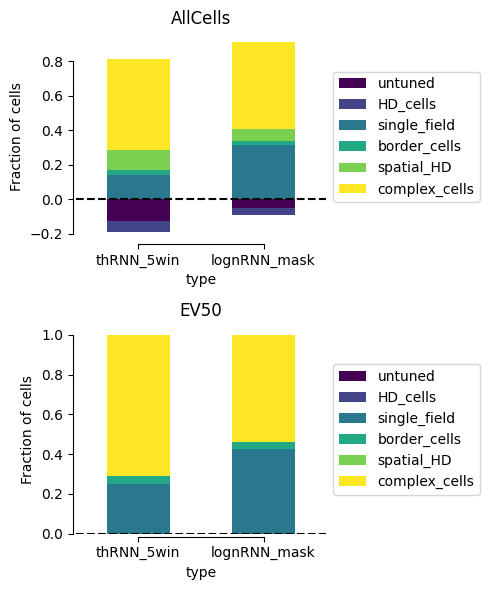

In [19]:
from prnn.utils.plotUtils import setNiceAxes, setPlotDefaults
import seaborn as sns
from prnn.utils.general import saveFig

names = ['AllCells','EV50']

fig, axes = plt.subplots(2, 1, figsize=(5, 6))  # Create two subplots side by side
#ax=[ax1, ax2]
for idx,frame in enumerate([fracFrame, fracFrame_welltuned]):
        ax=axes[idx]
        frame.plot(kind='bar', stacked=True, colormap='viridis', ax=ax)
        ax.plot(ax.get_xlim(), [0,0], 'k--')
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.set_ylabel('Fraction of cells')
        ax.set_title(names[idx])

        sns.despine(offset= 2, trim=True) 

#ax1.plot(np.abs(frame.loc['thRNN_5win']),np.abs(frame.loc['lognRNN_mask']),'.')

plt.tight_layout()
saveFig(fig,'CellTypeHists_'+names[idx],savefolder,
        filetype='pdf')
plt.show()


In [20]:
fracFrame_all = analysisFrame['groupFrac'].apply(pd.Series)
fracFrame_all.columns = [i for i in cellTypeNames]
fracFrame_all.index = analysisFrame['type']


fracFrame_welltuned_all = analysisFrame['groupFrac_welltuned'].apply(pd.Series)
fracFrame_welltuned_all.columns = [i for i in cellTypeNames]
fracFrame_welltuned_all.index = analysisFrame['type']

welltuned_stats = fracFrame_welltuned_all.groupby(fracFrame_welltuned_all.index).agg(['mean', 'std'])
all_stats = fracFrame_all.groupby(fracFrame_all.index).agg(['mean', 'std'])
all_stats

untuned           HD_cells           single_field            \
                mean       std     mean       std         mean       std   
type                                                                       
lognRNN_mask  0.0512  0.007193   0.0346  0.003134       0.3066  0.019552   
thRNN_5win    0.1364  0.008422   0.0656  0.010405       0.1394  0.015551   

             border_cells           spatial_HD           complex_cells  \
                     mean       std       mean       std          mean   
type                                                                     
lognRNN_mask       0.0366  0.006257     0.0706  0.008003        0.5004   
thRNN_5win         0.0242  0.006070     0.1150  0.004643        0.5194   

                        
                   std  
type                    
lognRNN_mask  0.024346  
thRNN_5win    0.021083

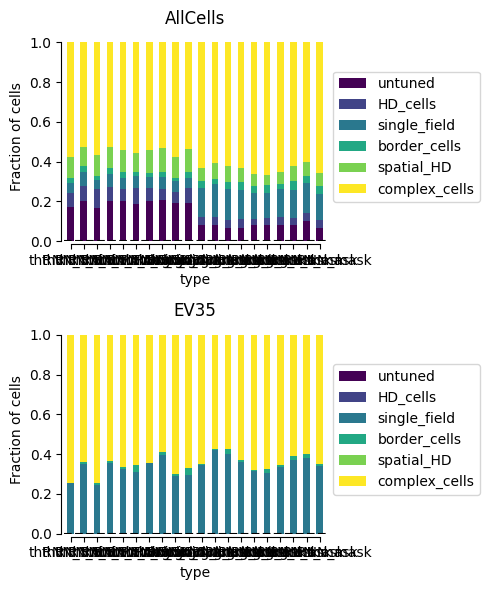

In [21]:
from prnn.utils.plotUtils import setNiceAxes, setPlotDefaults
import seaborn as sns
from prnn.utils.general import saveFig

names = ['AllCells','EV35']

fig, axes = plt.subplots(2, 1, figsize=(5, 6))  # Create two subplots side by side
#ax=[ax1, ax2]
for idx,frame in enumerate([fracFrame_all, fracFrame_welltuned_all]):
        ax=axes[idx]
        frame.plot(kind='bar', stacked=True, colormap='viridis', ax=ax)
        ax.plot(ax.get_xlim(), [0,0], 'k--')
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.set_ylabel('Fraction of cells')
        ax.set_title(names[idx])

        sns.despine(offset= 2, trim=True) 

#ax1.plot(np.abs(frame.loc['thRNN_5win']),np.abs(frame.loc['lognRNN_mask']),'.')

plt.tight_layout()
saveFig(fig,'CellTypeHists_all'+names[idx],savefolder,
        filetype='pdf')
plt.show()

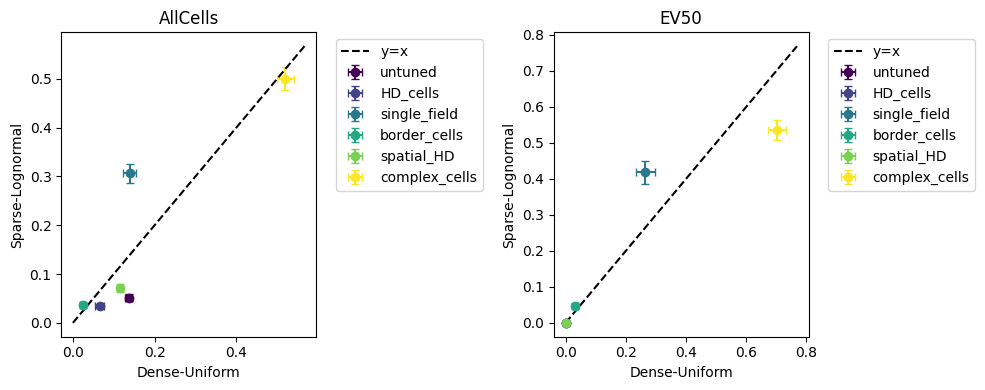

In [21]:
import matplotlib.cm as cm

# Create the plot
fig, axes = plt.subplots(1,2, figsize=(10, 4))
for idx, frame in enumerate([fracFrame_all,fracFrame_welltuned_all]):
    ax = axes[idx]
# Extract means and standard deviations
    means = frame.groupby(frame.index).mean()
    stds = frame.groupby(frame.index).std()

    # Extract data for thRNN_5win and lognRNN_mask
    x_means = means.loc['thRNN_5win']
    y_means = means.loc['lognRNN_mask']
    x_stds = stds.loc['thRNN_5win']
    y_stds = stds.loc['lognRNN_mask']

    # Generate a color array using the viridis colormap
    num_points = len(x_means)
    colors = cm.viridis(np.linspace(0, 1, num_points))  # Create a gradient of colors

    # Plot each column as a point with error bars and colors
    for i, (x, y, xerr, yerr, color) in enumerate(zip(x_means, y_means, x_stds, y_stds, colors)):
        ax.errorbar(
            x=x, y=y,
            xerr=xerr, yerr=yerr,
            fmt='o', color=color, capsize=3, label=x_means.index[i]
        )

    # Add a diagonal reference line
    max = np.max([ax.get_ylim()[1], ax.get_xlim()[1]])
    ax.plot([0, max], [0,max], 'k--', label='y=x')

    # Customize the plot
    ax.set_xlabel('Dense-Uniform')
    ax.set_ylabel('Sparse-Lognormal')
    ax.set_title(names[idx])
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

saveFig(fig,'CellTypeComparison',savefolder,
    filetype='pdf')
# Show the plot
plt.show()

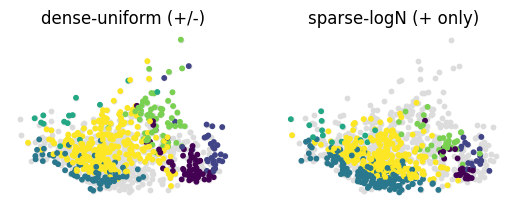

In [22]:
TCA_uniform = compareFrame.iloc[0].TCA
TCA_logN = compareFrame.iloc[1].TCA

from prnn.analysis.TuningCurveAnalysis import FitJointPCA
joint_metrics = FitJointPCA([TCA_uniform,TCA_logN])

names = ['dense-uniform (+/-)','sparse-logN (+ only)']
fig = plt.figure()
for idx,TCA in enumerate([TCA_uniform,TCA_logN]):
    plt.subplot(2,2,idx+1)
    TCA.pcaScatterPanel(color = TCA.groupID,joint=True, s=10)
    plt.title(names[idx])

saveFig(fig,'CellPCAMap',savefolder,
        filetype='pdf')

plt.show()

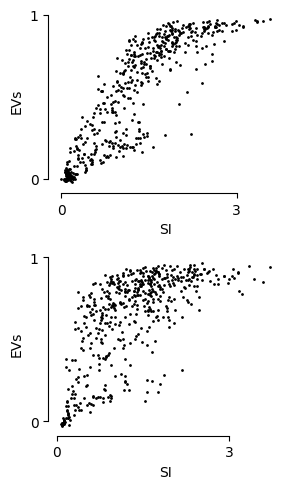

In [23]:
fig = plt.figure(figsize=(3,5))
plt.subplot(2,1,1)
plt.plot(TCA_uniform.metrics['SI'],TCA_uniform.metrics['EVs'],'k.',markersize=2)
plt.xlabel('SI')
plt.ylabel('EVs')
ylims = plt.ylim()
setNiceAxes() 

plt.subplot(2,1,2)
plt.plot(TCA_logN.metrics['SI'],TCA_logN.metrics['EVs'],'k.',markersize=2)
plt.xlabel('SI')
plt.ylabel('EVs')
plt.ylim(ylims)
setNiceAxes() 
plt.tight_layout()

saveFig(fig,'SIEV',savefolder,
        filetype='pdf')

plt.show()

In [25]:
from prnn.utils.agent import RatInABoxAgent

WAKEactivity = TCA_uniform.runWAKE(predictiveNet_uniform, predictiveNet_uniform.EnvLibrary[0],
                                   RatInABoxAgent('RiaB'), 50000,
                                        theta='expand')

Running WAKE


In [40]:
FAKEactivity = {'state':WAKEactivity['state']}
position = WAKEactivity['state']['agent_pos']
WAKE_h = WAKEactivity['h']
FAKEactivity['h'] = np.zeros_like(WAKEactivity['h'])

for cell,(k,tuning_curve) in enumerate(TCA_uniform.tuning_curves.items()):
    if np.isnan(tuning_curve).all(): continue
    FAKEactivity['h'][:,cell] = tuning_curve[position[:WAKE_h.shape[0],0],
                                            position[:WAKE_h.shape[0],1]]

In [88]:
predictiveNet_initLogN = PredictiveNet(predictiveNet_logN.EnvLibrary[0], pRNNtype='lognRNN_rollout', 
                                      dataloader=False, hidden_size=predictiveNet_logN.trainArgs.hiddensize, neuralTimescale=1,
                                      eg_lr=1e-2, mean_std_ratio=predictiveNet_logN.trainArgs.mean_std_ratio, sparsity=predictiveNet_logN.trainArgs.sparsity)
predictiveNet_inituniform = PredictiveNet(predictiveNet_logN.EnvLibrary[0], pRNNtype='thRNN_5win', 
                                      dataloader=False, hidden_size=predictiveNet_logN.trainArgs.hiddensize)


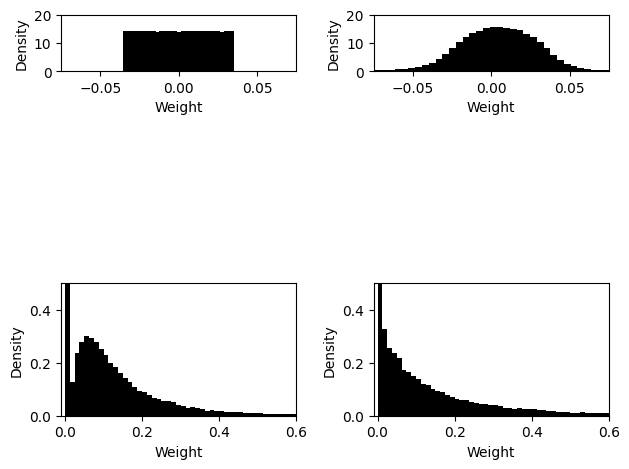

In [89]:


fig=plt.figure()
plt.subplot(2,2,3)
plt.hist(predictiveNet_initLogN.pRNN.W.detach().numpy().flatten()[:], range=(0, 1), bins=80,density=True, facecolor='k')
plt.xlim([-0.01,0.6])
plt.ylim([0,0.5])
plt.xlabel('Weight')
plt.ylabel('Density')

plt.subplot(4,2,1)
plt.hist(predictiveNet_inituniform.pRNN.W.detach().numpy().flatten()[:], bins=250,density=True, facecolor='k')
plt.xlim([-0.075,0.075])
plt.ylim([0,20])
plt.xlabel('Weight')
plt.ylabel('Density')

plt.subplot(2,2,4)
plt.hist(predictiveNet_logN.pRNN.W.detach().numpy().flatten()[:], range=(0, 1), bins=80,density=True, facecolor='k')
plt.xlim([-0.01,0.6])
plt.ylim([0,0.5])
plt.xlabel('Weight')
plt.ylabel('Density')

plt.subplot(4,2,2)
plt.hist(predictiveNet_uniform.pRNN.W.detach().numpy().flatten()[:], bins=250,density=True, facecolor='k')
plt.xlim([-0.075,0.075])
plt.ylim([0,20])
plt.xlabel('Weight')
plt.ylabel('Density')


plt.tight_layout()

saveFig(fig,'ExHists',savefolder,
        filetype='pdf')
plt.show()

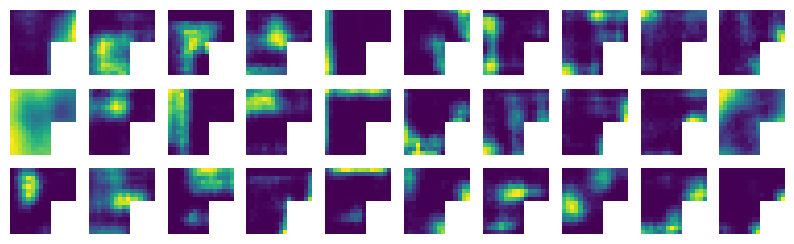

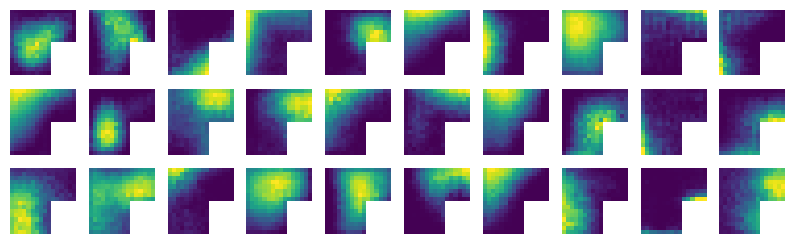

In [90]:

TCA_uniform.cellGroupExamplesFigure(netname='Uniform', savefolder = savefolder,
                                    groupID=TCA_uniform.metrics['EVs']>0.5, 
                                    sortby=TCA_uniform.groupID, dims=[3,10])
TCA_logN.cellGroupExamplesFigure(netname='LogN', savefolder = savefolder,
                                 groupID=TCA_logN.metrics['EVs']>0.5,
                                 sortby=TCA_logN.groupID, dims=[3,10])

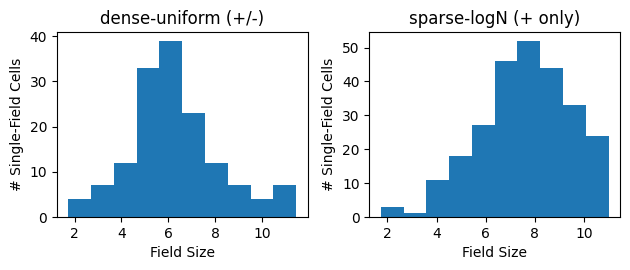

In [100]:
plt.figure()
for idx,TCA in enumerate([TCA_uniform,TCA_logN]):
    plt.subplot(2,2,idx+1)
    plt.hist(TCA.metrics['fieldsize'][TCA.cellgroups['single_field']])
    plt.xlabel('Field Size')
    plt.title(names[idx])
    plt.ylabel('# Single-Field Cells')

plt.tight_layout()
plt.show()

Running WAKE


/home/mila/d/daniel.levenstein/pRNN/prnn/analysis/representationalGeometryAnalysis.py:380: RuntimeWarning: invalid value encountered in divide
  hist2 = hist2/np.sum(hist2,axis=0)
/home/mila/d/daniel.levenstein/pRNN/prnn/analysis/representationalGeometryAnalysis.py:381: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  RSA = spearmanr(dists[value],obs_dists[value])


Running SLEEP
Fitting Isomap


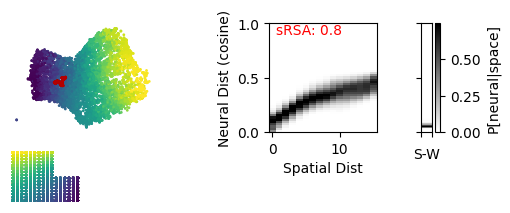

Running WAKE


/home/mila/d/daniel.levenstein/pRNN/prnn/analysis/representationalGeometryAnalysis.py:380: RuntimeWarning: invalid value encountered in divide
  hist2 = hist2/np.sum(hist2,axis=0)
/home/mila/d/daniel.levenstein/pRNN/prnn/analysis/representationalGeometryAnalysis.py:381: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  RSA = spearmanr(dists[value],obs_dists[value])


Running SLEEP
Fitting Isomap


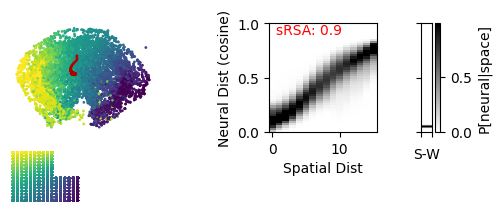

In [47]:
from prnn.analysis.representationalGeometryAnalysis import representationalGeometryAnalysis

sleepnoise = 0.1
isomap_neighbors = 15
RGA_uniform = representationalGeometryAnalysis(predictiveNet_uniform,noisemag = 0, noisestd=sleepnoise, 
                                       withIsomap=True, n_neighbors = isomap_neighbors)
RGA_uniform.WakeSleepFigure(None,None)
RGA_logN = representationalGeometryAnalysis(predictiveNet_logN,noisemag = 0, noisestd=sleepnoise, 
                                       withIsomap=True, n_neighbors = isomap_neighbors)
RGA_logN.WakeSleepFigure(None,None)

In [48]:
#analysisFrame
grouped_stats = analysisFrame.groupby('type')['dhInf','dx_half'].agg(['mean', 'std'])

/tmp/ipykernel_3201889/3158169203.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_stats = analysisFrame.groupby('type')['dhInf','dx_half'].agg(['mean', 'std'])


/home/mila/d/daniel.levenstein/pRNN/prnn/analysis/representationalGeometryAnalysis.py:836: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(t_plot, y_fitted, 'r-', linewidth=2,


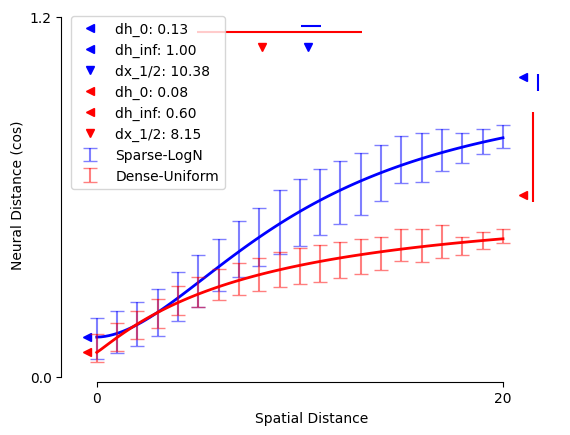

In [57]:

fig = plt.figure()
RGA_logN.hillFitPanel(RGA_logN.hill_fit,color='b',datalabel='Sparse-LogN')
RGA_uniform.hillFitPanel(RGA_uniform.hill_fit,color='r',datalabel='Dense-Uniform')

colors = ['r','b']
for idx,net in enumerate(['thRNN_5win','lognRNN_mask']):
    plt.errorbar(21.5+0.2*idx,grouped_stats['dhInf','mean'][net],
                 yerr=grouped_stats['dhInf','std'][net],
                 fmt='none',color=colors[idx])

    plt.errorbar(grouped_stats['dx_half','mean'][net],1.15+0.02*idx,
                 xerr=grouped_stats['dx_half','std'][net],
                 fmt='none', color=colors[idx])

setNiceAxes()
saveFig(fig,'OrthogGeometry',savefolder,
        filetype='pdf')
        
plt.show()